In [29]:
import pandas as pd
import scanpy as sc

In [30]:
adata = sc.read_h5ad("./output/adata_v2.h5ad")

In [31]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'cell_type', 'dpt_pseudotime'
    var: 'n_counts', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_anno_colors', 'louvain_anno_sizes', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca', 'tsne'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Read the transition indicies
---

In [32]:
def read_tab_separated_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    data = []
    for line in lines:
        # Strip any surrounding whitespace and split by tabs
        numbers = line.strip().split(', ')
        # Convert the strings to integers or floats
        numbers = [str(int(num)) for num in numbers]
        data.append(numbers)
    
    return data

transition_indicies_filepath = './data/transition_indices.txt'
data_cell_indicies = read_tab_separated_file(transition_indicies_filepath)


In [33]:
data_cell_indicies[0]

['56',
 '233',
 '266',
 '998',
 '1156',
 '1379',
 '1497',
 '1659',
 '2063',
 '2266',
 '2315',
 '2464',
 '2637']

### Read the cell pairs file

In [34]:
def read_tab_separated_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    data = []
    for line in lines:
        # Strip any surrounding whitespace and split by tabs
        cells = line.strip().split(', ')
        # Convert the strings to integers or floats
        cells = [str(cell) for cell in cells]
        data.append(cells)
    
    return data

cell_pairs_filepath = './data/cell_pairs.txt'
data_cell_pairs = read_tab_separated_file(cell_pairs_filepath)

In [35]:
data_cell_pairs

[['Ery0', 'Ery1'],
 ['Ery1', 'Ery3'],
 ['HPC', 'Monocyte Progenitor'],
 ['Ery3', 'Ery4'],
 ['HPC', 'Monocyte Progenitor', 'Neutrophils'],
 ['Ery0', 'Ery2', 'Ery3', 'Ery4'],
 ['Ery0', 'Ery4'],
 ['Monocyte Progenitor', 'Neutrophils'],
 ['Early Progenitor', 'HPC'],
 ['HPC', 'Neutrophils'],
 ['Early Progenitor', 'Ery4'],
 ['Ery4', 'Mep'],
 ['Ery0', 'Ery2', 'Ery4'],
 ['Ery0', 'Ery3', 'Ery4'],
 ['Basophil', 'HPC'],
 ['Basophil', 'Neutrophils'],
 ['Ery4', 'HPC', 'Neutrophils'],
 ['Ery2', 'Ery4'],
 ['Ery0', 'Mep'],
 ['Ery0', 'HPC', 'Neutrophils'],
 ['Basophil', 'HPC', 'Neutrophils'],
 ['HPC', 'Lymph'],
 ['Ery0', 'HPC', 'Monocyte Progenitor', 'Neutrophils'],
 ['Ery0', 'Ery3'],
 ['Ery0', 'HPC'],
 ['Ery0', 'Monocyte Progenitor', 'Neutrophils'],
 ['DC', 'HPC']]

### Make a copy of cell_type column in obs dataframe and name it as cell_type_w_hybrids

In [36]:
adata.obs

,paul15_clusters,n_counts_all,louvain,louvain_anno,cell_type,dpt_pseudotime
0,7MEP,353.0,8,8,Ery4,0.225547
1,15Mo,2556.0,1,1,Monocyte Progenitor,0.273524
2,3Ery,4649.0,17,17,Ery0,0.710179
3,15Mo,4486.0,2,2,Neutrophils,0.267904
4,3Ery,5205.0,17,17,Ery0,0.781939
...,...,...,...,...,...,...
2725,2Ery,4873.0,6,6,Ery1,0.649140
2726,13Baso,3553.0,24,24/Mo,Monocyte Progenitor,0.298521
2727,7MEP,443.0,8,8,Ery4,0.196117
2728,15Mo,3252.0,2,2,Neutrophils,0.264164


In [37]:
adata.obs["cell_type_w_hybrids"] = adata.obs['cell_type']

In [38]:
assert len(data_cell_indicies) == len(data_cell_pairs)

In [39]:
for idx in range(len(data_cell_indicies)):
    indices = data_cell_indicies[idx]
    cell_types = data_cell_pairs[idx]
    cell_type_name_hyb = "-".join(cell_types) + "-Hybrid"
    adata.obs['cell_type_w_hybrids'].cat.add_categories(cell_type_name_hyb, inplace=True)
    # Rename the cell_type for the given indices to 'xyz'
    adata.obs.loc[indices, 'cell_type_w_hybrids'] = cell_type_name_hyb

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [40]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rc_context

In [41]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=200, frameon=False, figsize=(3, 3), facecolor="white", color_map="viridis_r")

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.5.0
anyio               NA
arrow               1.2.3
attr                23.2.0
babel               2.14.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
certifi             2024.07.04
cffi                1.15.1
charset_normalizer  3.3.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.7.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastjsonschema      NA
fqdn                NA
h5py                3.8.0
idna                3.7
igraph              0.10.8
importlib_resources NA
ipykernel           6.16.2
ipython_genutils    0.2.0
isoduration         NA
jedi                0.19.1
jinja2              3.1.4
joblib              1.3.2
json5               NA
jsonpointer         3.0.0
jsonschema          4.17.3
jupyter_server      1.24.0
jupyterlab_server   2.24.0
kiwisolver          1.4.5


In [42]:
adata_raw = sc.datasets.paul15()

/usr/local/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [43]:
adata_raw.obs = adata.obs

In [44]:
del adata

In [45]:
adata_raw.obs

,paul15_clusters,n_counts_all,louvain,louvain_anno,cell_type,dpt_pseudotime,cell_type_w_hybrids
0,7MEP,353.0,8,8,Ery4,0.225547,Ery4
1,15Mo,2556.0,1,1,Monocyte Progenitor,0.273524,Monocyte Progenitor
2,3Ery,4649.0,17,17,Ery0,0.710179,Ery0
3,15Mo,4486.0,2,2,Neutrophils,0.267904,Neutrophils
4,3Ery,5205.0,17,17,Ery0,0.781939,Ery0
...,...,...,...,...,...,...,...
2725,2Ery,4873.0,6,6,Ery1,0.649140,Ery1
2726,13Baso,3553.0,24,24/Mo,Monocyte Progenitor,0.298521,Monocyte Progenitor
2727,7MEP,443.0,8,8,Ery4,0.196117,Ery4
2728,15Mo,3252.0,2,2,Neutrophils,0.264164,Neutrophils


### 1.

In [18]:
sc.pp.log1p(adata_raw)

In [46]:
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler



# Prepare data
X = adata_raw.obs['dpt_pseudotime'].values.reshape(-1, 1)  # Pseudotime as independent variable
gene_names = adata_raw.var_names
differential_expression_results = {}

# Run linear regression for each gene
for gene in tqdm(gene_names):
    y = adata_raw[:, gene].X.toarray().flatten()  # Expression of the gene as dependent variable
    # Scale the data
    X_clean = X[~np.isinf(X).any(axis=1)]
    y_clean = y[~np.isinf(X).any(axis=1)]
    model = LinearRegression().fit(X_clean, y_clean)
    differential_expression_results[gene] = model.coef_[0]  # Store the slope (correlation with pseudotime)

# Sort genes by their pseudotime correlation
sorted_genes = sorted(differential_expression_results.items(), key=lambda x: abs(x[1]), reverse=True)
top_genes = sorted_genes[:25]

# Visualize or export top genes
print(top_genes)

100%|██████████| 3451/3451 [00:15<00:00, 217.91it/s]

[('Car2', 71.370865), ('Car1', 53.642334), ('Rpl4', 47.29311), ('Gnb2l1', 44.47228), ('Mpo', -41.27106), ('Hsp90ab1', 38.52644), ('Rps3', 35.428493), ('Prtn3', -33.95712), ('Gm10653', 33.36937), ('Ncl', 31.96222), ('Eef2', 30.603165), ('Actb', 29.498806), ('AK158095', 28.014887), ('Fth1', 25.319986), ('Rpl13a', 24.372574), ('Atpif1', 23.277227), ('Atp5b', 22.975033), ('Elane', -21.284994), ('Fam132a', 20.335564), ('Prdx2', 18.714306), ('Tubb5', 18.016397), ('Gpx1', 16.805244), ('Ctsg', -16.541529), ('Tuba1b', 16.11978), ('Rps20', 15.502922)]


## Iteration

In [47]:
cell_types_groups_list = []
for idx in range(len(data_cell_indicies)):
    cell_types = []
    cell_types_list = []
    indices = data_cell_indicies[idx].copy()
    cell_types = data_cell_pairs[idx].copy()
    cell_type_name_hyb = "-".join(cell_types) + "-Hybrid"
    cell_types.append(cell_type_name_hyb)
    cell_types_groups_list.append(cell_types)

In [48]:
def get_filtered_adata(cells_list: list,):
    filtered_adata = adata_raw[adata_raw.obs["cell_type_w_hybrids"].isin(cells_list)]
    sc.pp.log1p(filtered_adata)
    sorted_adata = filtered_adata[np.argsort(filtered_adata.obs['dpt_pseudotime'])]
    sc.tl.rank_genes_groups(sorted_adata,groupby="cell_type_w_hybrids")
    return sorted_adata

In [49]:
import pandas as pd
import numpy as np
import scipy
def get_sorted_gene_list(adata_tmp,group1,group2):
    # Ensure that 'group' column exists and contains the groups
    if 'cell_type_w_hybrids' not in adata_tmp.obs.columns:
        raise ValueError("The 'group' column is missing from adata.obs")

    # Check if adata.raw is present
    if adata_tmp.raw is not None:
        expression_matrix = adata_tmp.raw.X
        gene_names = adata_tmp.raw.var_names
    else:
        expression_matrix = adata_tmp.X
        gene_names = adata_tmp.var_names

    # If the expression matrix is sparse, convert it to a dense array
    if scipy.sparse.issparse(expression_matrix):
        expression_matrix = expression_matrix.toarray()

    # Create a DataFrame for mean expression calculation
    expression_df = pd.DataFrame(expression_matrix, columns=gene_names, index=adata_tmp.obs.index)

    # Ensure that the index of expression_df matches the index of adata.obs
    if not expression_df.index.equals(adata_tmp.obs.index):
        raise ValueError("The index of expression_df does not match the index of adata.obs")
    # Calculate mean expression in each group
    mean_expr_group1 = expression_df[adata_tmp.obs['cell_type_w_hybrids'] == group1].mean()
    mean_expr_group2 = expression_df[adata_tmp.obs['cell_type_w_hybrids'] == group2].mean()

    # Calculate the difference in mean expression between groups
    #difference = mean_expr_group1 - mean_expr_group2

    # Sort genes based on the difference in mean expression
    #sorted_genes = difference.sort_values(ascending=False).index.tolist()
    # Calculate Log2 Fold Change
    log2_fc = np.log2((mean_expr_group1 + 1) / (mean_expr_group2 + 1))  # Adding 1 to avoid division by zero

    # Sort genes based on Log2 Fold Change
    sorted_genes = log2_fc.sort_values(ascending=False).index.tolist()
    # If you have a specific list of genes you want to sort
    specific_genes = [gene for gene, _ in top_genes]  # Replace with your gene list
    specific_genes_sorted = [gene for gene in sorted_genes if gene in specific_genes]
    return specific_genes_sorted

In [50]:
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
import numpy as np
def plot_matrix(sorted_adata_tmp,categories_order: list,idx: int,
                specific_genes_sorted: list,
                save: bool = False, name:str = ""):
    with rc_context({
        "figure.figsize": (9, 6),
        "xtick.labelsize": 0.5,
        "ytick.labelsize": 0.5,
        "axes.labelsize": 0.5,  # Font size for axis labels
        "axes.titlesize": 2   # Font size for titles
    }):
        
        # Generate the matrix plot and get the figure and axis objects
        fig, ax = plt.subplots()
        sc.pl.rank_genes_groups_matrixplot(
            sorted_adata_tmp,
            var_names=specific_genes_sorted[:25],
            values_to_plot="scores",
            ax=ax,
            cmap="bwr",
            categories_order=categories_order,
            min_logfoldchange=3,
            show=False,  # Do not show the plot immediately
            dendrogram=False,
            swap_axes=True,
            colorbar_title='Scores'
        )

        # Customize the plot further using matplotlib
        ax.set_title("Top Differentially Expressed Genes", fontsize=10)
        ax.set_xlabel("Cell Types/Clusters", fontsize=4)
        ax.set_ylabel("Genes", fontsize=2)

        # Optionally customize the tick parameters
        ax.tick_params(axis='x', labelsize=0.2, rotation=45)
        ax.tick_params(axis='y', labelsize=0.5,size=2,rotation=45)

        # Save the plot
        if save:
            plt.savefig(f"./output/DGE/{idx}_{name}_matrixplot.png",bbox_inches='tight')
        plt.show()

In [51]:
idx = -1

In [129]:
idx+=1
print(idx)
print(cell_types_groups_list[idx])

27


IndexError: list index out of range

In [128]:

adata = get_filtered_adata(cells_list=cell_types_groups_list[idx])
specific_genes_sorted = get_sorted_gene_list(adata_tmp=adata,
                                            group1="DC",
                                            group2="HPC",
                                            )
plot_matrix(sorted_adata_tmp=adata,
            categories_order=cell_types_groups_list[idx],
            idx=idx,
            specific_genes_sorted=specific_genes_sorted
           )

ranking genes


ValueError: Could not calculate statistics for groups DC-HPC-Hybrid since they only contain one sample.

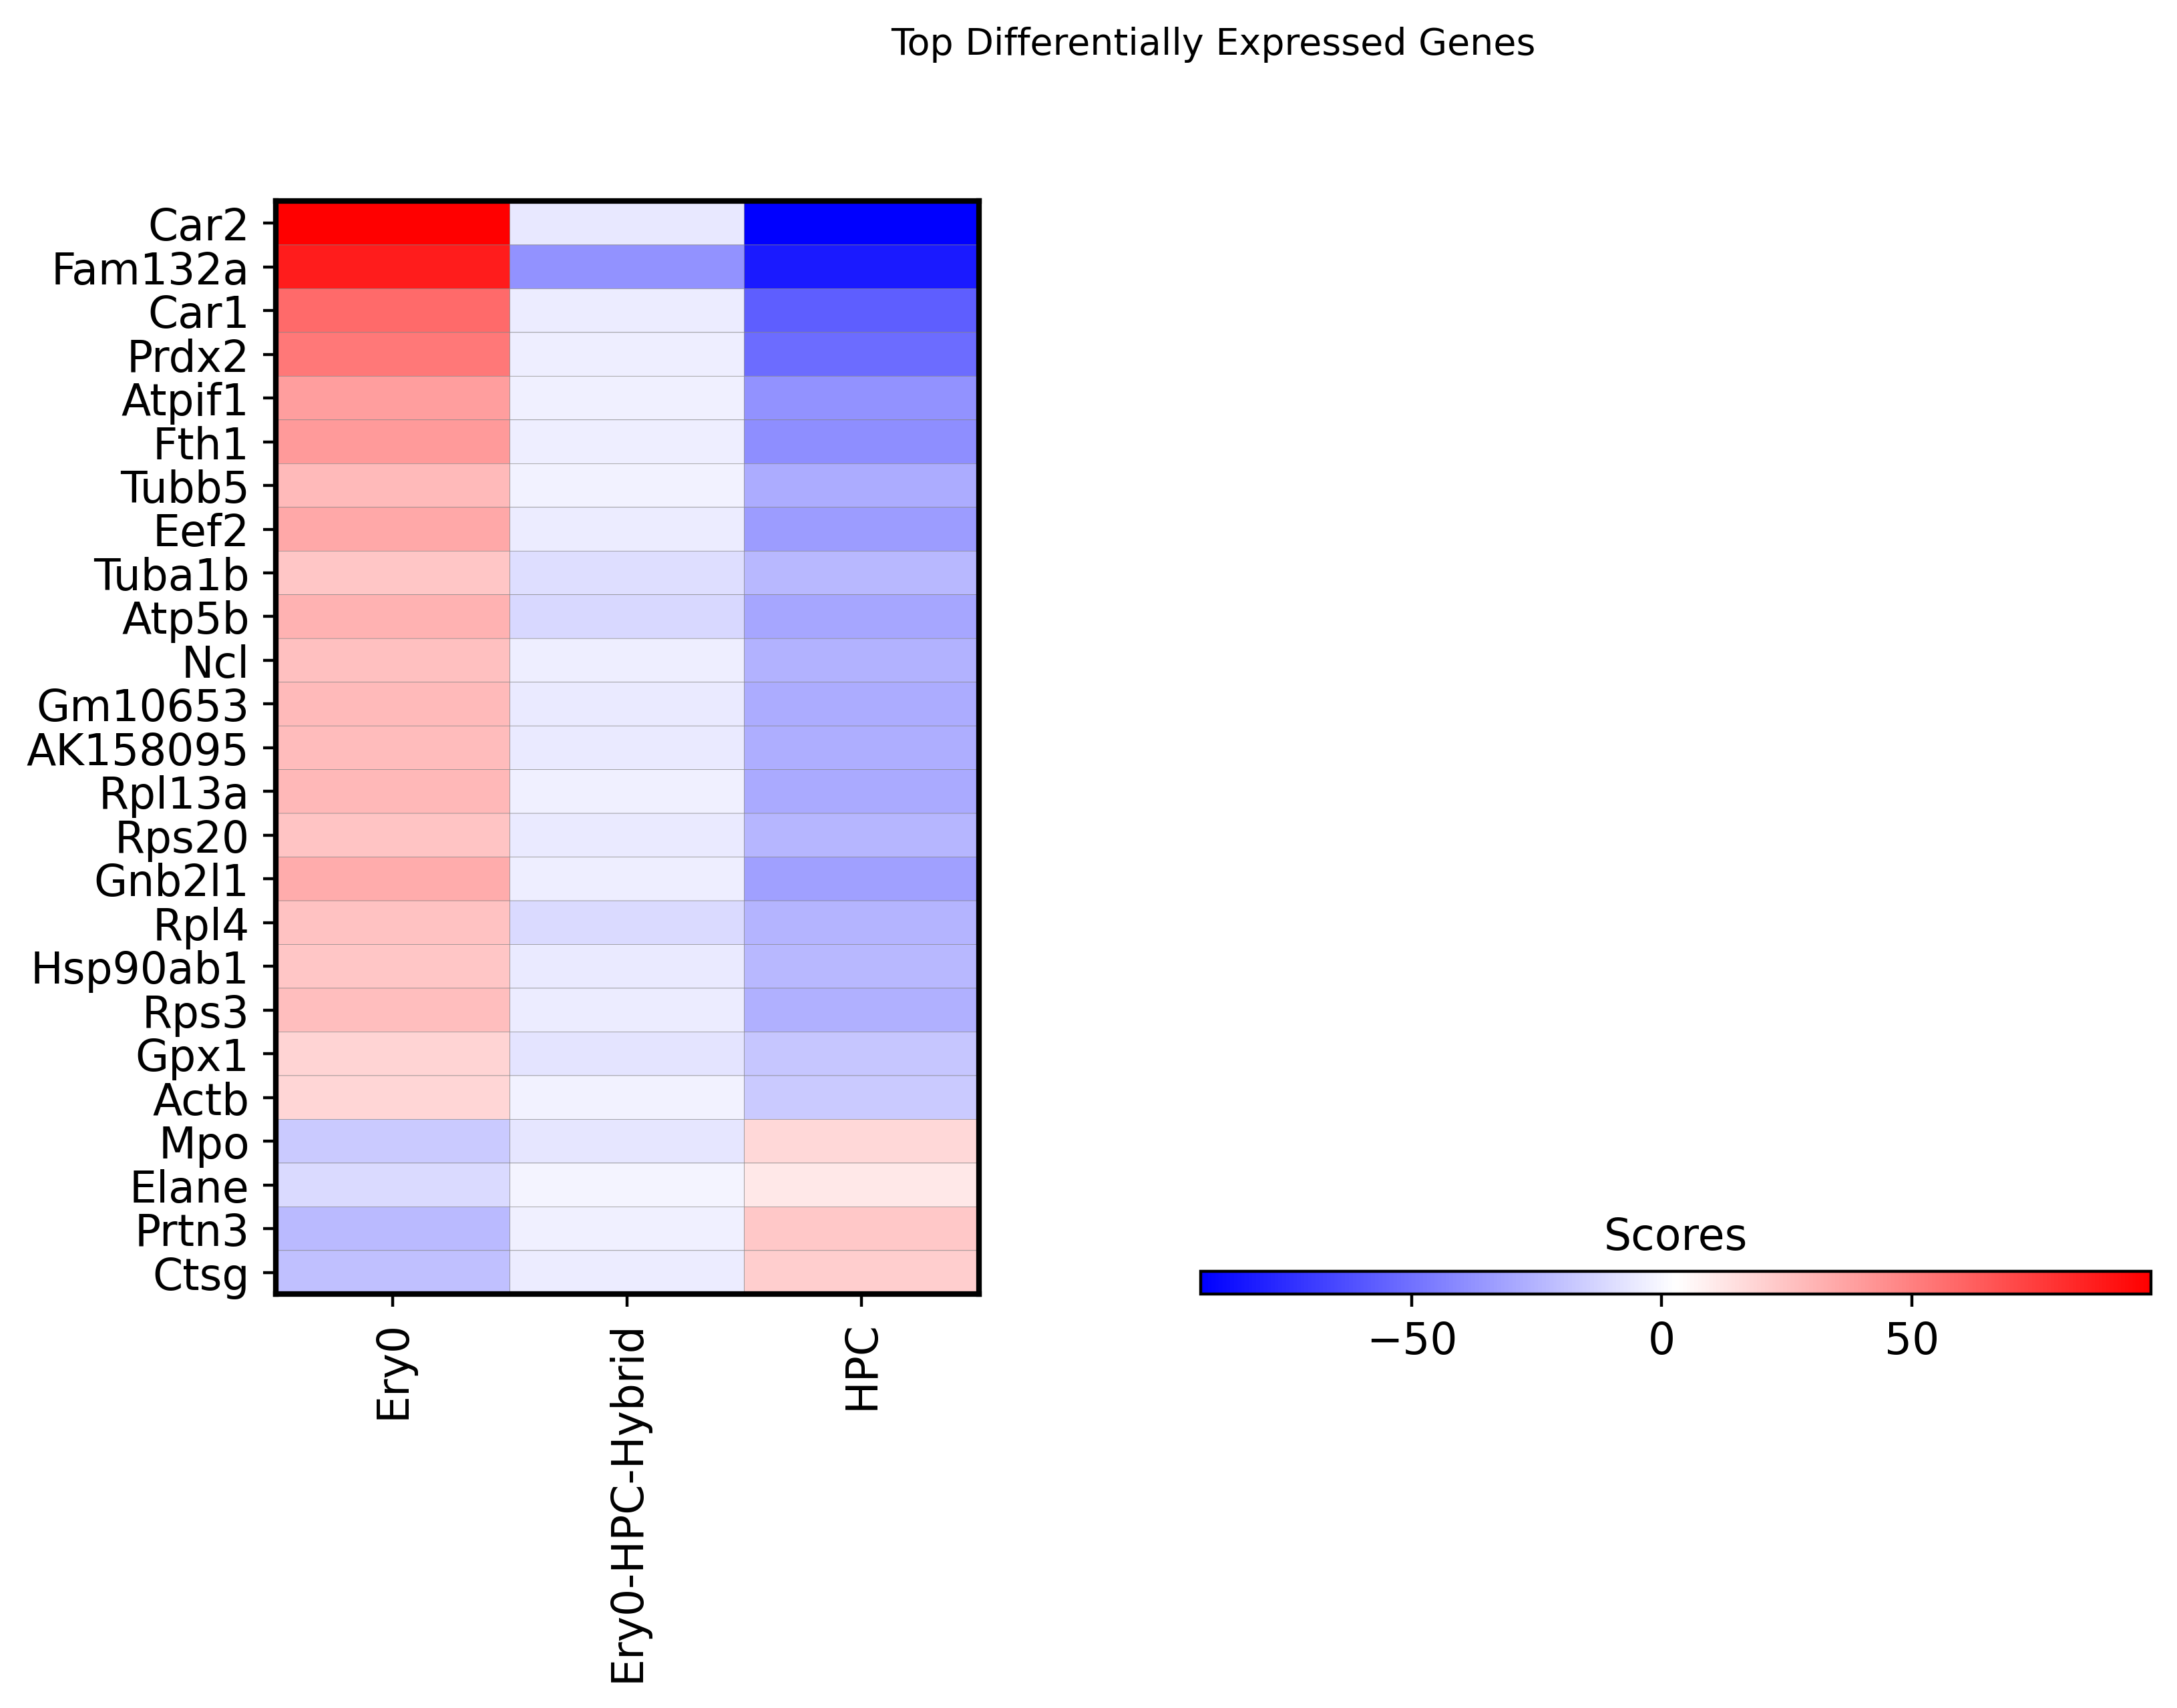

In [124]:
plot_matrix(sorted_adata_tmp=adata,
            categories_order=['Ery0', 'Ery0-HPC-Hybrid','HPC'],
            idx=idx,
            save=True,
            name=cell_types_groups_list[idx][-1],
            specific_genes_sorted=specific_genes_sorted
           )